# 신용카드 사기 탐지 분류 문제

이 노트북의 다음 라이브러리 버전은 "파이썬 머신러닝 완벽 가이드 개정2판"을 기준으로 설정되었습니다.

### 라이브러리 버전
2. `xgboost` : 1.5.0
3. `lightgbm` : 3.3.2

### 기타 사용 라이브러리
1. `hyperopt`

In [1]:
!pip uninstall -y xgboost lightgbm

Found existing installation: xgboost 3.1.1
Uninstalling xgboost-3.1.1:
  Successfully uninstalled xgboost-3.1.1
Found existing installation: lightgbm 3.3.2
Uninstalling lightgbm-3.3.2:
  Successfully uninstalled lightgbm-3.3.2


In [50]:
!pip install xgboost==1.5.0 lightgbm==3.3.2 numpy==1.26.4 scikit-learn==1.3.0

  Using cached xgboost-1.5.0-py3-none-manylinux2014_x86_64.whl.metadata (1.7 kB)
  Using cached lightgbm-3.3.2-py3-none-manylinux1_x86_64.whl.metadata (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 67.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached xgboost-1.5.0-py3-none-manylinux2014_x86_64.whl (173.5 MB)
Using cached lightgbm-3.3.2-py3-none-manylinux1_x86_64.whl (2.0 MB)
  Created wheel for scikit-learn: filename=scikit_learn-1.3.0-cp312-cp312-linux_x86_64.whl size=10672940 sha256=0dc09525670bd42d2926cdf4659f17227f35f439903c1a23bfbd56667cb948d4
  Stored in directory: /root/.cache/pip/wheels/dc/e7/56/cae51184980f4c0f7bc63c40ccecad85060b79f19452e19b14
Successfully built scikit-learn
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.1
    Uninstalling xgboost-3.1.1:
      Successfully uninstalled xgboost-3.1.1
  Attempting un

In [3]:
!pip install hyperopt

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 훈련 데이터와 테스트 데이터는 미리 준비되어 있습니다.

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# 데이터셋 정보

2013년 9월 유럽 신용카드 사용자들의 거래 내역을 포함하고 있습니다.
이 데이터셋은 이틀 간의 거래 내역으로 데이터셋은 크게 불균형하며, 사기 거래(양성 클래스)는 전체 거래의 약 0.17%에 불과합니다.

이 데이터셋은 PCA 변환을 거친 수치형 변수들만 포함하고 있습니다. 안타깝게도 기밀 유지 문제로 인해 원본 특징과 데이터에 대한 자세한 배경 정보는 제공할 수 없습니다. V1, V2, …, V28은 PCA로 얻은 주성분이며, PCA 변환을 거치지 않은 유일한 특징은 'Time'과 'Amount'입니다. 'Time'은 각 거래와 데이터셋의 첫 거래 사이의 경과 시간(초)을 나타내며, 'Amount'는 거래 금액입니다. 'Amount' 특징은 예시 의존적 비용 민감 학습 등에 사용될 수 있습니다. 'Class'는 응답 변수로, 사기 거래인 경우 1, 그렇지 않은 경우 0의 값을 가집니다.

클래스 불균형 비율을 고려하여, 정밀도-재현율 곡선 아래 영역(AUPRC)을 사용하여 정확도를 측정할 것을 권장합니다. 불균형 분류에서는 혼동 행렬 정확도가 큰 의미가 없습니다.

이 데이터셋은 Worldline과 ULB(브뤼셀 자유 대학교) 머신러닝 그룹(http://mlg.ulb.ac.be) 간의 빅데이터 마이닝 및 사기 탐지 관련 연구 협력을 통해 수집 및 분석되었습니다.
관련 주제에 대한 현재 및 과거 프로젝트에 대한 자세한 내용은 https://www.researchgate.net/project/Fraud-detection-5 및 DefeatFraud 프로젝트 페이지에서 확인할 수 있습니다.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113923 entries, 0 to 113922
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      113923 non-null  int64  
 1   Time    113923 non-null  float64
 2   V1      113923 non-null  float64
 3   V2      113923 non-null  float64
 4   V3      113923 non-null  float64
 5   V4      113923 non-null  float64
 6   V5      113923 non-null  float64
 7   V6      113923 non-null  float64
 8   V7      113923 non-null  float64
 9   V8      113923 non-null  float64
 10  V9      113923 non-null  float64
 11  V10     113923 non-null  float64
 12  V11     113923 non-null  float64
 13  V12     113923 non-null  float64
 14  V13     113923 non-null  float64
 15  V14     113923 non-null  float64
 16  V15     113923 non-null  float64
 17  V16     113923 non-null  float64
 18  V17     113923 non-null  float64
 19  V18     113923 non-null  float64
 20  V19     113923 non-null  float64
 21  V20     11

# 뼈대 만들기

머신러닝 파이프라인은

데이터 준비 → 모델 정의 → 학습 → 예측 → 평가의 형태를 띕니다.

최소한의 형태로 파이프라인만 구성해 보겠습니다.

In [3]:
train_copy = train_df.copy()
train_copy.drop('Time', axis=1, inplace=True)

In [4]:
X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [6]:
print('학습 데이터 간 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('검증 데이터 간 레이블 값 비율')
print(y_val.value_counts()/y_val.shape[0] * 100)

학습 데이터 간 레이블 값 비율
Class
0    99.789329
1     0.210671
Name: count, dtype: float64
검증 데이터 간 레이블 값 비율
Class
0    99.789332
1     0.210668
Name: count, dtype: float64


In [12]:
from sklearn.linear_model import LogisticRegression

# 학습
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)

# 검증
lr_val = lr_clf.predict(X_val)
lr_val_proba = lr_clf.predict_proba(X_val)[:,1]

print('학습 완료!')

학습 완료!


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

lr_val_confusion = confusion_matrix(y_val, lr_val)
lr_val_accuracy = accuracy_score(y_val, lr_val)
lr_val_precision = precision_score(y_val, lr_val)
lr_val_recall = recall_score(y_val, lr_val)
lr_val_f1 = f1_score(y_val, lr_val)

lr_val_roc_score = roc_auc_score(y_val, lr_val_proba)
print(lr_val_roc_score)

print("검증 데이터 혼동행렬:")
print(lr_val_confusion)
print("검증 데이터 정확도: ",lr_val_accuracy)
print("검증 데이터 정밀도: ",lr_val_precision)
print("검증 데이터 재현율: ",lr_val_recall)
print("검증 데이터 F1 점수: ",lr_val_f1)
print("검증 데이터 AUC: ",lr_val_roc_score)


0.9633741386893417
검증 데이터 혼동행렬:
[[34092    13]
 [   29    43]]
검증 데이터 정확도:  0.9987711033736139
검증 데이터 정밀도:  0.7678571428571429
검증 데이터 재현율:  0.5972222222222222
검증 데이터 F1 점수:  0.671875
검증 데이터 AUC:  0.9633741386893417


In [14]:

X_test_features = test_df.copy()
X_test_features.drop('Time', axis=1, inplace=True)


# 예측
lr_prob = lr_clf.predict(X_test_features)

# 제출용 DataFrame
submission = pd.DataFrame({
    "id": test_df["id"],   # 반드시 원래 test.csv에 있던 id 사용
    "Class": lr_prob
})

# csv 파일 저장
submission.to_csv("./submission.csv", index=False)


In [15]:
submission

,id,Class
0,170883,0
1,170884,0
2,170885,0
3,170886,0
4,170887,0
...,...,...
113918,284801,0
113919,284802,0
113920,284803,0
113921,284804,0


# **기본 통계 및 결측값 확인**

In [16]:
# 데이터의 형태 확인
train_df.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [17]:
test_df.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,...,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000
mean,227844.000000,145396.169808,0.254759,-0.061154,-0.739555,-0.176137,0.264150,-0.087346,0.120988,-0.048337,...,-0.046430,0.042428,0.125609,0.033672,-0.013512,-0.138398,-0.018897,-0.003140,-0.003667,89.867850
std,32886.881696,14553.200321,2.084808,1.708359,1.402141,1.461789,1.399511,1.381543,1.269186,1.140927,...,0.831851,0.718441,0.788888,0.678614,0.615591,0.567769,0.468657,0.420530,0.361528,256.236008
min,170883.000000,120396.000000,-46.855047,-50.383269,-48.325589,-5.683171,-113.743307,-20.869626,-23.386192,-39.688571,...,-54.497720,-21.620120,-7.417140,-36.666000,-2.790479,-8.696627,-1.855355,-9.895244,-15.430084,0.000000
25%,199363.500000,132928.500000,-0.803531,-0.691506,-1.598860,-0.978315,-0.437285,-0.880171,-0.491675,-0.273015,...,-0.247537,-0.223898,-0.534543,-0.142571,-0.382480,-0.450968,-0.313872,-0.075609,-0.062317,5.950000
50%,227844.000000,145247.000000,0.117889,-0.005846,-0.734520,-0.337083,0.250458,-0.389808,0.153525,-0.035902,...,-0.104920,0.036139,0.186973,0.040791,0.016358,-0.193153,-0.041566,-0.009555,-0.028507,22.450000
75%,256324.500000,157639.500000,1.978707,0.803286,0.121444,0.431529,0.882923,0.309498,0.746755,0.285891,...,0.091959,0.253758,0.750595,0.227957,0.524460,0.221885,0.214766,0.093824,0.078238,78.000000
max,284805.000000,172788.000000,2.454930,12.730564,3.937048,15.304184,29.162172,73.301626,120.589494,12.766112,...,23.643417,20.063786,8.272233,22.528412,4.584549,6.070850,3.415636,31.612198,16.129609,25691.160000


In [18]:
# 결측치 확인
train_df.isnull().sum()

,0
id,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0


In [19]:
# Class 불균형 확인
train_df['Class'].value_counts(normalize=True)

,proportion
Class,
0,0.997893
1,0.002107


In [20]:
# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 데이터 구조 확인
print(train_df.shape)
print(train_df.info())
print(train_df['Class'].value_counts(normalize=True))


(170883, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 2

/tmp/ipython-input-2732369823.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=train_df, palette='Set2')


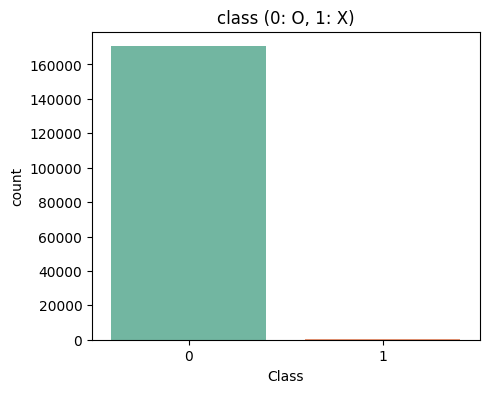

In [21]:
plt.figure(figsize=(5,4))
sns.countplot(x='Class', data=train_df, palette='Set2')
plt.title('class (0: O, 1: X)')
plt.xlabel('Class')
plt.show()


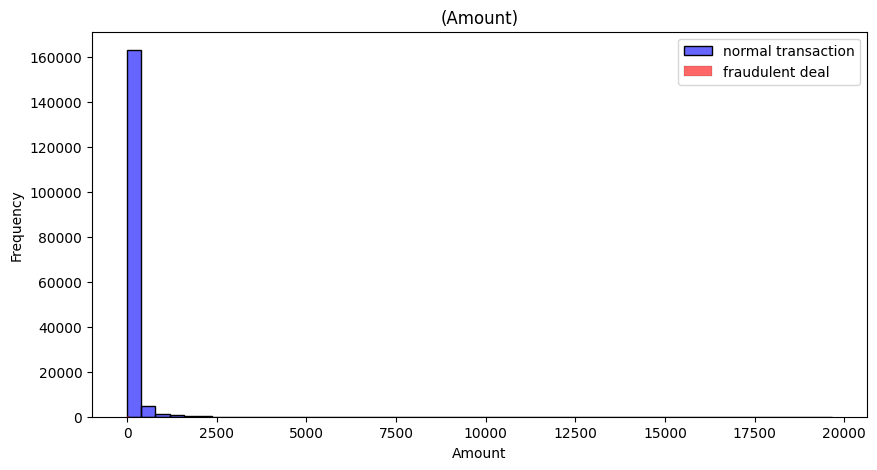

In [22]:
plt.figure(figsize=(10,5))
sns.histplot(train_df[train_df['Class']==0]['Amount'], bins=50, color='blue', label='normal transaction', alpha=0.6)
sns.histplot(train_df[train_df['Class']==1]['Amount'], bins=50, color='red', label='fraudulent deal', alpha=0.6)
plt.legend()
plt.title('(Amount)')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


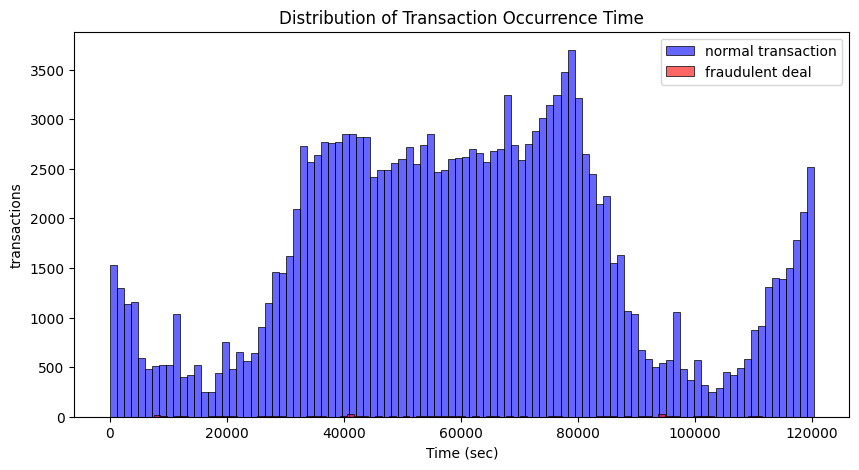

In [23]:
plt.figure(figsize=(10,5))
sns.histplot(train_df[train_df['Class']==0]['Time'], bins=100, color='blue', label='normal transaction', alpha=0.6)
sns.histplot(train_df[train_df['Class']==1]['Time'], bins=100, color='red', label='fraudulent deal', alpha=0.6)
plt.legend()
plt.title('Distribution of Transaction Occurrence Time')
plt.xlabel('Time (sec)')
plt.ylabel('transactions')
plt.show()


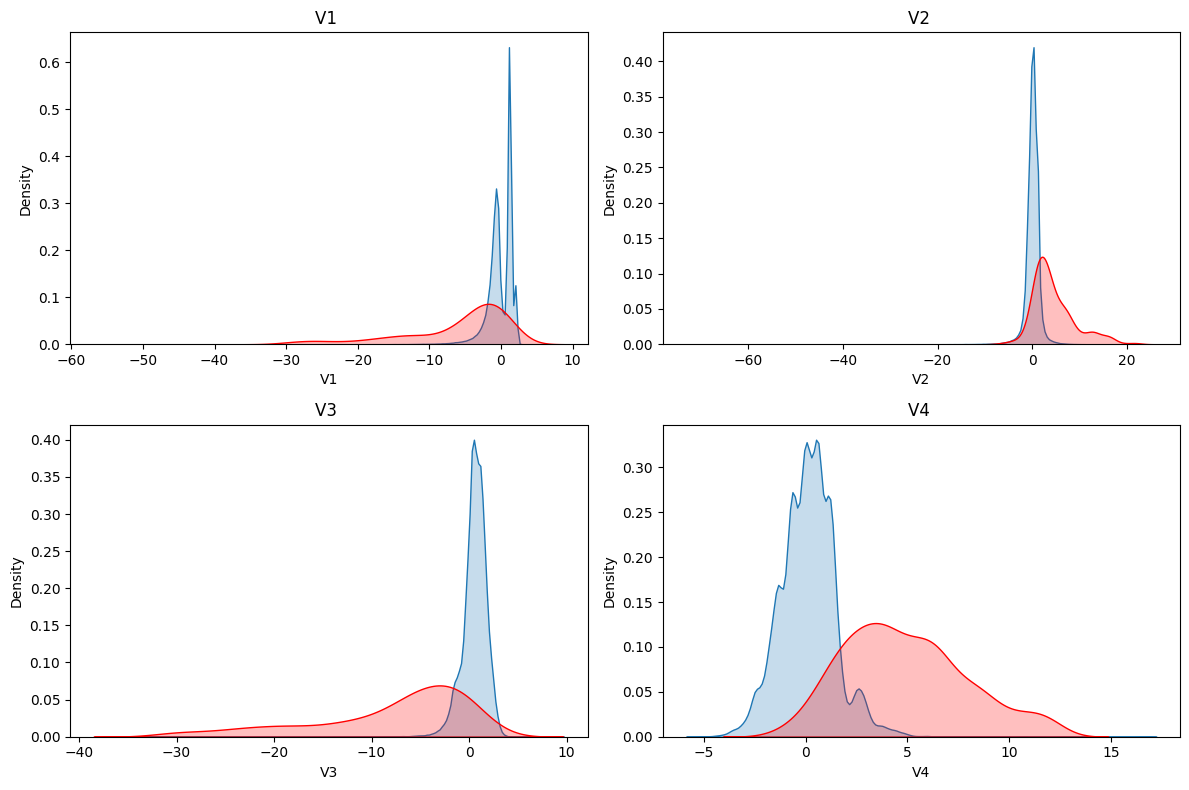

In [24]:
# V1~V4만 시각화 변수들의 차이를 보기위해
cols = ['V1', 'V2', 'V3', 'V4']
plt.figure(figsize=(12,8))
for i, col in enumerate(cols, 1):
    plt.subplot(2,2,i)
    sns.kdeplot(train_df[train_df['Class']==0][col], label='normal', fill=True)
    sns.kdeplot(train_df[train_df['Class']==1][col], label='Fraud', fill=True, color='red')
    plt.title(f'{col} ')
plt.tight_layout()
plt.show()


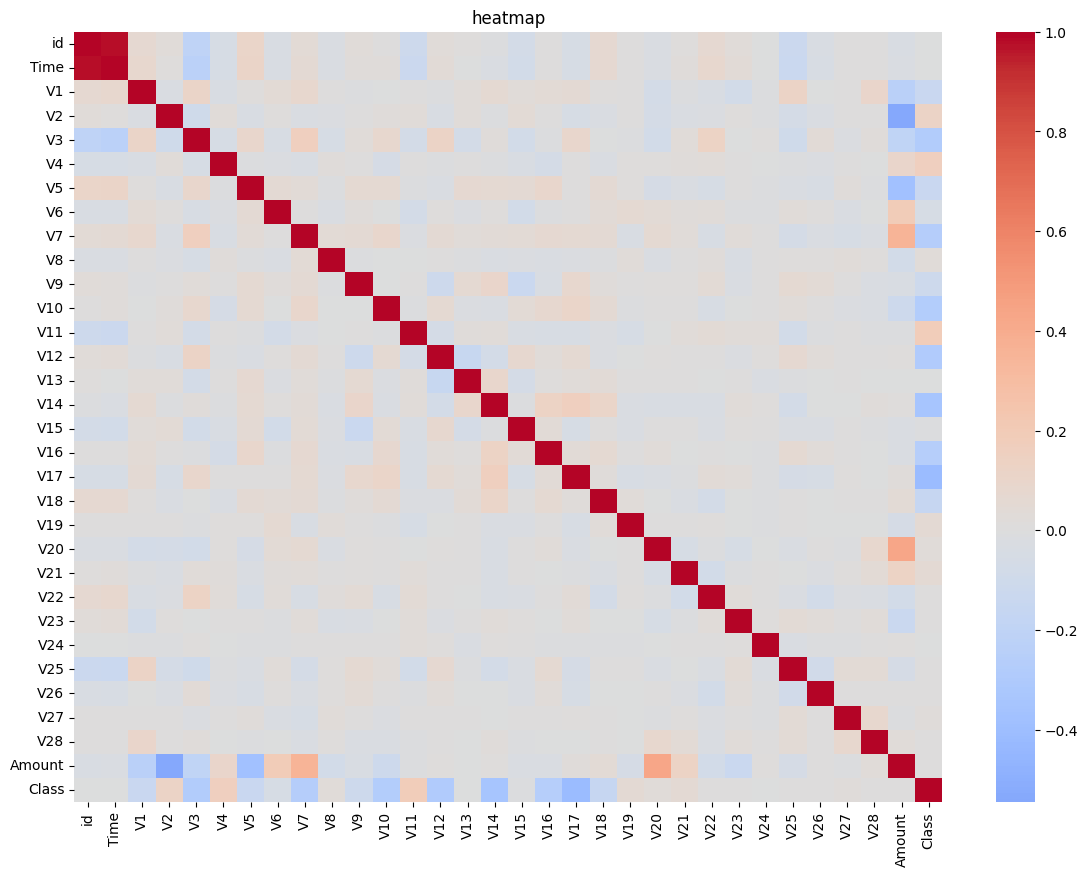

V17    0.412954
V14    0.345635
V12    0.287091
V3     0.281337
V10    0.275925
V7     0.263719
V16    0.256496
V11    0.181917
V4     0.159813
V18    0.156770
Name: Class, dtype: float64


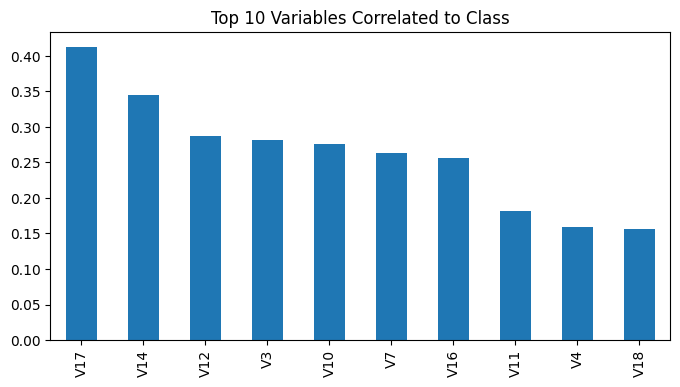

In [25]:
# 상관관계 히트맵
plt.figure(figsize=(14,10))
corr = train_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('heatmap')
plt.show()

# Class와의 상관관계 상위 10개
corr_with_class = corr['Class'].abs().sort_values(ascending=False)[1:11]
print(corr_with_class)
corr_with_class.plot(kind='bar', figsize=(8,4), title='Top 10 Variables Correlated to Class')
plt.show()


/tmp/ipython-input-2685306088.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=col, data=train_df, palette='Set2')
/tmp/ipython-input-2685306088.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=col, data=train_df, palette='Set2')
/tmp/ipython-input-2685306088.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=col, data=train_df, palette='Set2')
/tmp/ipython-input-2685306088.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x

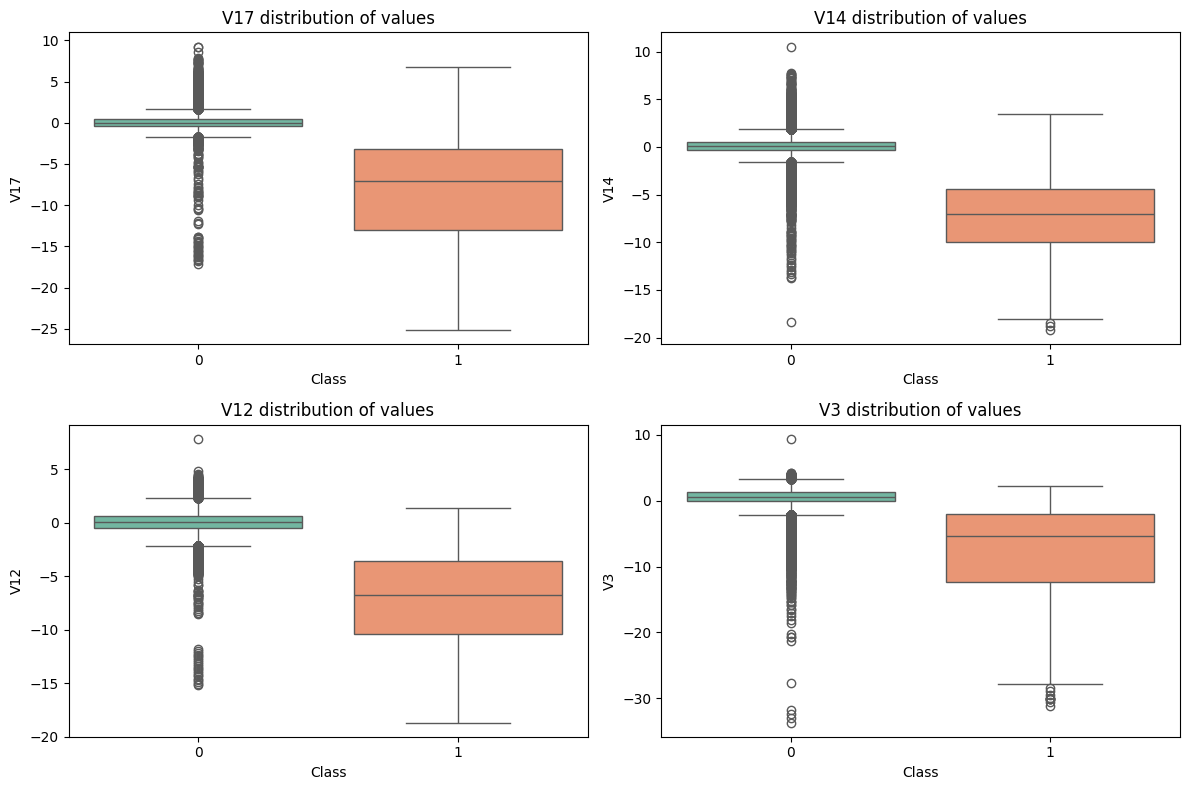

In [26]:
# 상관관계 높은 변수 시각화 후 패턴 보기
important_features = corr_with_class.index[:4]

plt.figure(figsize=(12,8))
for i, col in enumerate(important_features, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x='Class', y=col, data=train_df, palette='Set2')
    plt.title(f'{col} distribution of values')
plt.tight_layout()
plt.show()


# **데이터 전처리**

In [7]:
# 데이터 분리
from sklearn.model_selection import train_test_split

X = train_df.drop(['id', 'Class'], axis=1)
y = train_df['Class']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
# 데이터 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_valid[['Time', 'Amount']] = scaler.transform(X_valid[['Time', 'Amount']])
test_df[['Time', 'Amount']] = scaler.transform(test_df[['Time', 'Amount']])

In [9]:
# 데이터 불균형 처리
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# **모델 학습**

In [32]:
!pip install pandas>=2.2.0 xgboost>=2.1.0 scikit-learn>=1.5.0

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

models = {
    'LR': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'RF': RandomForestClassifier(n_estimators=200, max_depth=6, class_weight='balanced', random_state=42)
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_valid)
    print(f"{name} F1-score:", f1_score(y_valid, preds))


LR F1-score: 0.13993541442411195
RF F1-score: 0.6213592233009708


In [11]:
#  DataFrame → numpy array로 변환
X_train_np = X_train_res.values
y_train_np = y_train_res.values
X_valid_np = X_valid.values
y_valid_np = y_valid.values

#  클래스 불균형 비율에 맞춰 가중치 계산
scale_pos_weight = (len(y_train_np) - sum(y_train_np)) / sum(y_train_np)

#  XGBoost 모델 정의
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # 경고 방지
)

#  모델 학습
xgb_model.fit(X_train_np, y_train_np)

#  예측 및 F1-score 계산
y_pred_xgb = xgb_model.predict(X_valid_np)
f1 = f1_score(y_valid_np, y_pred_xgb)

print(f" XGBoost F1-score: {f1:.4f}")


/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


 XGBoost F1-score: 0.7000


In [36]:
xgb_model.fit(X_train_res.values, y_train_res.values)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    class_weight='balanced',
    random_state=42
)

# 두 모델 따로 학습
xgb_model.fit(X_train_res, y_train_res)
rf_model.fit(X_train_res, y_train_res)

# 검증 세트 확률 예측
xgb_probs = xgb_model.predict_proba(X_valid)[:, 1]
rf_probs = rf_model.predict_proba(X_valid)[:, 1]

# soft voting (가중 평균)
ensemble_probs = (0.7 * xgb_probs) + (0.3 * rf_probs)

# 확률을 0.5 기준으로 이진 변환
ensemble_preds = (ensemble_probs > 0.5).astype(int)

print(" Ensemble (manual soft voting) F1:", f1_score(y_valid, ensemble_preds))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:14:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:14:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Ensemble (manual soft voting) F1: 0.7241379310344828


In [37]:
from sklearn.linear_model import LogisticRegression
#  Ridge (L2 규제)
ridge_lr = LogisticRegression(
    penalty='l2',
    C=0.5,  # 규제 강도
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)

#  Lasso (L1 규제)
lasso_lr = LogisticRegression(
    penalty='l1',
    solver='liblinear',  # L1은 liblinear 또는 saga 필요
    C=0.5,
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)

#  ElasticNet (L1 + L2 혼합)
elastic_lr = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,  # 0=L2, 1=L1, 0.5=혼합
    C=0.5,
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)

# 모델 학습
ridge_lr.fit(X_train_res, y_train_res)
lasso_lr.fit(X_train_res, y_train_res)
elastic_lr.fit(X_train_res, y_train_res)

# 예측
ridge_preds = ridge_lr.predict(X_valid)
lasso_preds = lasso_lr.predict(X_valid)
elastic_preds = elastic_lr.predict(X_valid)

# F1 계산
print(" Ridge F1:", f1_score(y_valid, ridge_preds))
print(" Lasso F1:", f1_score(y_valid, lasso_preds))
print(" ElasticNet F1:", f1_score(y_valid, elastic_preds))


 Ridge F1: 0.14023732470334413
 Lasso F1: 0.14099783080260303
 ElasticNet F1: 0.1400862068965517


In [38]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('ridge', ridge_lr)
    ],
    voting='soft',
    weights=[3, 2, 1]
)

ensemble.fit(X_train_res, y_train_res)
ensemble_preds = ensemble.predict(X_valid)
print(" Ensemble (XGB+RF+Ridge) F1:", f1_score(y_valid, ensemble_preds))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:24:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Ensemble (XGB+RF+Ridge) F1: 0.7150837988826816


In [28]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(
        learning_rate=0.05,
        max_depth=3,
        n_estimators=200,
        random_state=42
    ),
    stack_method='predict_proba'
)

stack_model.fit(X_train_res.values, y_train_res.values)
preds = stack_model.predict(X_valid.values)
print(" Stacking F1:", f1_score(y_valid, preds))


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 Stacking F1: 0.22550831792975973


In [29]:
# test 데이터 전처리
X_test_features = test_df.drop(columns=['Time'], errors='ignore')

# 예측
stack_preds = stack_model.predict(X_test_features.values)

# 제출 파일 생성
submission = pd.DataFrame({
    "id": test_df["id"],
    "Class": stack_preds
})

# CSV 저장
submission.to_csv("./submission_stack.csv", index=False)

print("submission_stack.csv 생성 완료!")


submission_stack.csv 생성 완료!


In [48]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# ------------------------------
#  베이스 모델 설정 (튜닝)
# ------------------------------
xgb_model = XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=250,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    min_child_weight=3,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=3,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

# ------------------------------
#  스태킹 앙상블 정의
# ------------------------------
estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(
        C=0.8,
        penalty='l2',   # Ridge 규제
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    ),
    stack_method='predict_proba',
    n_jobs=-1
)

# ------------------------------
#  학습 및 검증
# ------------------------------
stack_model.fit(X_train_res, y_train_res)
preds = stack_model.predict(X_valid)

f1 = f1_score(y_valid, preds)
print(f" Tuned Stacking F1: {f1:.4f}")


 Tuned Stacking F1: 0.4791


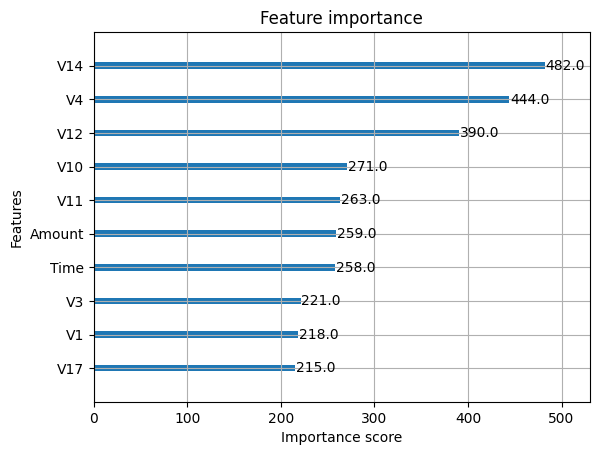

In [46]:
# 어떤 변수가 사기거래를 잘 표현하는지
from xgboost import plot_importance
plot_importance(xgb_model, max_num_features=10)
plt.show()

In [13]:
import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

if not hasattr(pd, 'Int64Index'):
    pd.Int64Index = pd.Index

# ============================================
#  1. 탐색 공간 정의
# ============================================
xgb_search_space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.95),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.02, 0.2),
    'gamma': hp.uniform('gamma', 0, 0.3)
}

# ============================================
#  2. 목적 함수 정의 (Hyperopt용)
# ============================================
def objective_func(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])

    xgb_clf = XGBClassifier(
        n_estimators=300,
        random_state=42,
        eval_metric='auc',
        use_label_encoder=False,
        tree_method='hist',   # 빠르고 안정적인 학습
        **params
    )

    roc_auc_list = []
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    for tr_idx, val_idx in kf.split(X_train):  # ⚠️ SMOTE 전 원본 데이터 사용
        X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

        #  최신 XGB 방식: callbacks로 EarlyStopping 지정
        xgb_clf.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[EarlyStopping(rounds=30, save_best=True, maximize=True)],
            verbose=False
        )

        preds = xgb_clf.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, preds)
        roc_auc_list.append(score)

    mean_auc = np.mean(roc_auc_list)
    return {'loss': -mean_auc, 'status': STATUS_OK}

# ============================================
#  3. 하이퍼파라미터 최적화 실행
# ============================================
trials = Trials()
best_params = fmin(
    fn=objective_func,
    space=xgb_search_space,
    algo=tpe.suggest,
    max_evals=25,     # 25회 탐색 (보통 20~50이면 충분)
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("\n Best Params Found by Hyperopt:")
print(best_params)

# ============================================
#  4. 최적 파라미터로 최종 모델 학습 (SMOTE 데이터)
# ============================================
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

xgb_final = XGBClassifier(
    n_estimators=400,
    random_state=42,
    eval_metric='auc',
    use_label_encoder=False,
    tree_method='hist',
    **best_params
)

# 여기서는 SMOTE로 오버샘플링된 데이터 사용
xgb_final.fit(X_train_res, y_train_res)

# ============================================
#  5. 검증 세트 평가
# ============================================
from sklearn.metrics import f1_score, roc_auc_score

val_preds = xgb_final.predict(X_valid)
val_probs = xgb_final.predict_proba(X_valid)[:, 1]

f1 = f1_score(y_valid, val_preds)
auc = roc_auc_score(y_valid, val_probs)

print(f"\n Final Validation Results")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")


100%|██████████| 25/25 [02:30<00:00,  6.03s/trial, best loss: -0.9877068422155498]

✅ Best Params Found by Hyperopt:
{'colsample_bytree': 0.722239931392345, 'gamma': 0.2980218077025694, 'learning_rate': 0.12322297449514376, 'max_depth': 3.0, 'min_child_weight': 5.0, 'subsample': 0.9169895211023081}

 Final Validation Results
F1-score: 0.7241
ROC-AUC: 0.9786


In [20]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.3 MB/s eta 0:00:00


In [21]:
import optuna
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# ==============================
#  튜닝할 대상: XGBClassifier
# ==============================
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.2),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma': trial.suggest_float('gamma', 0, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400)
    }

    model = XGBClassifier(
        **params,
        eval_metric='auc',
        use_label_encoder=False,
        tree_method='hist',
        random_state=42
    )

    model.fit(X_train_res.values, y_train_res.values)
    preds = model.predict(X_valid.values)
    f1 = f1_score(y_valid, preds)
    return f1

# Optuna 실행
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=25)
print(" Best XGB params:", study_xgb.best_params)
print("Best F1:", study_xgb.best_value)


[I 2025-11-07 07:32:17,700] A new study created in memory with name: no-name-1a003af3-7d9a-48ac-8338-3643068e2cf3
[I 2025-11-07 07:32:22,475] Trial 0 finished with value: 0.823529411764706 and parameters: {'max_depth': 7, 'learning_rate': 0.18889918565633984, 'subsample': 0.9055166871755309, 'colsample_bytree': 0.6481962134039874, 'min_child_weight': 6, 'gamma': 0.19167957328507232, 'n_estimators': 103}. Best is trial 0 with value: 0.823529411764706.
[I 2025-11-07 07:32:33,515] Trial 1 finished with value: 0.8571428571428572 and parameters: {'max_depth': 7, 'learning_rate': 0.18177046082734022, 'subsample': 0.7252981937565751, 'colsample_bytree': 0.6991109926746404, 'min_child_weight': 6, 'gamma': 0.0944866857877246, 'n_estimators': 290}. Best is trial 1 with value: 0.8571428571428572.
[I 2025-11-07 07:32:41,183] Trial 2 finished with value: 0.875 and parameters: {'max_depth': 10, 'learning_rate': 0.17625751371760798, 'subsample': 0.9741327040989659, 'colsample_bytree': 0.7344747011602

✅ Best XGB params: {'max_depth': 9, 'learning_rate': 0.141991221591186, 'subsample': 0.939372467247858, 'colsample_bytree': 0.9029889047054783, 'min_child_weight': 1, 'gamma': 0.19526776435232523, 'n_estimators': 345}
Best F1: 0.8936170212765957


In [23]:
import pandas as pd
from xgboost import XGBClassifier

best_params = study_xgb.best_params

best_xgb = XGBClassifier(
    **best_params,
    eval_metric='auc',
    use_label_encoder=False,
    tree_method='hist',
    random_state=42
)

best_xgb.fit(X_train_res.values, y_train_res.values)

X_test_features = test_df.drop(columns=['Time'], errors='ignore')

test_preds = best_xgb.predict(X_test_features.values)

submission = pd.DataFrame({
    "id": test_df["id"],
    "Class": test_preds
})

submission.to_csv("./submission.csv", index=False)

print("Optuna 최적 모델로 예측 완료 — submission.csv 파일 생성됨")


Optuna 최적 모델로 예측 완료 — submission.csv 파일 생성됨
